# Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import squarify
import spacy
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

/mnt/d/MEGA/MÀSTER MODELLING/2 - Mathematics for Big Data/3. DeepLearning/MBD_NN/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Download and load catalan stopwords from `spacy`.

In [2]:
!python -m spacy download ca_core_news_sm
nlp = spacy.load("ca_core_news_sm")
stopwords = nlp.Defaults.stop_words
print(stopwords)

/mnt/d/MEGA/MÀSTER MODELLING/2 - Mathematics for Big Data/3. DeepLearning/MBD_NN/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 34.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
{'altres', 'com', "m'he", 'mon', 'aquelles', 'pel', 'tot', 'meu', 'últim', 'inclòs', 'la', 'igual', 'teus', 'ser', 'conseguim', 'faig', 'baix', 'mateix', 'ma', 'nosaltres', 'moltes', 'que', 'nogensmenys', 'tampoc', 'aleshores', 'dalt', 'des', 'teniu', 'tenim', 'consigueix', 'tots', 'mentre', 'ne', 'tanta', 'ni', 'sap', 'al', 'estava', 'poc', "d'unes", 'però', 'sabeu', 'saben', 'em', 'nostre', 'també', 'això', 'erem', 'molts', 'solament', 'et', 'tenir', "n'hi", 'ús', 'conseguir', 'estàvem', 'vostre', 'seu', 'pocs', 'i', 'ambdues', "d'un", 'molta', 'estan', 'havia', 'soc', 'eren', '

# Load and process csv data

In [3]:
data = pd.read_csv('../data/train.csv')

In [4]:
texts = data['text']
labels = data['class']
year = data['year']

## Remove stopwords + leading and trailing quotes

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    text = " ".join(word for word in text.split() if word not in stopwords)
    return text

preprocessed_texts = []
for sentence in texts:
    preprocessed_texts.append(preprocess_text(sentence))

In [6]:
print(np.random.choice(preprocessed_texts, 15, replace=False))

['oferta pblica docupaci'
 'citaci comparixer notificar diversos actes naturalesa tributria'
 'exposici pblic modificaci lordenana fiscal nm reguladora taxa prestaci serveis dintervenci administrativa ciutadans'
 'licitaci contracte serveis suport implantaci llei transparncia dret daccs informaci'
 'licitaci ladquisici dos vehicles patrullers dues motocicletes transformats degudament equipats servei gurdia urbana'
 'exposici pblic compte general' 'notificaci duna ordre suspensi dobres'
 'notificaci infructuosa dun recurs reposici'
 'aprovaci definitiva projecte dobres millora infraestructura servei sanejament lavinguda cornell'
 'aprovaci inicial projecte executiu construcci dun paviment s esportiu recinte lescola poblenou'
 'delegaci competncies lalcaldia tinent dalcalde'
 'aprovaci dun reglament modificacions dordenances modificaci crdit'
 'notificaci imposici duna sanci'
 'formalitzaci contracte relatiu rehabilitaci tancaments edificis ledar llobregat fase'
 'contractaci temporal ur

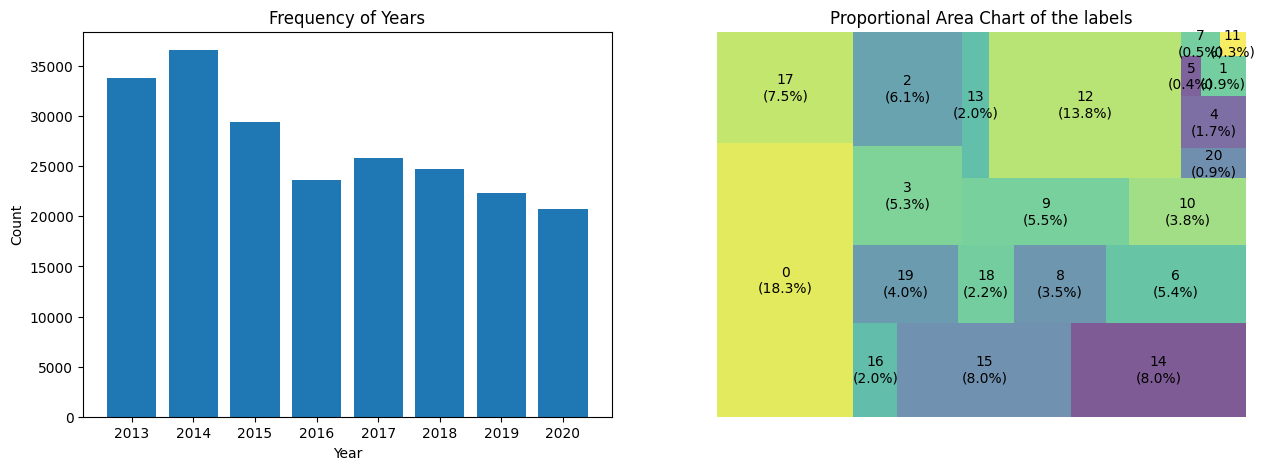

In [7]:
year_counts = Counter(year)
sorted_years = sorted(year_counts)
frequencies_years = [year_counts[year] for year in sorted_years]

lable_counts = Counter(labels)
sorted_lables = sorted(lable_counts)
frequencies_labels = [lable_counts[label] for label in sorted_lables]
labels_with_pct = [f"{label}\n({size/sum(frequencies_labels):.1%})" for label, size in lable_counts.items()]

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].bar(sorted_years, frequencies_years)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Frequency of Years')


squarify.plot(sizes=lable_counts.values(), label=labels_with_pct, alpha=0.7, ax=ax[1])
ax[1].axis('off')
ax[1].set_title("Proportional Area Chart of the labels")

# ax[1].bar(sorted_lables, frequencies_labels)
# ax[1].set_xlabel('Label')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Label Frequencies')

plt.show()

## Plot the WordCloud

In [14]:
def TermDocMatrix(corpus):
    vec = TfidfVectorizer(max_features=1000)
    X = vec.fit_transform(corpus)
    df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out())
    return df

def CreateWordCloud(tdm,
                    save_file=True,):
    words = tdm.columns  
    word_freq = {}
    for _, row in tdm.iterrows():
        for i, count in enumerate(row):
            word = words[i]
            word_freq[word] = word_freq.get(word, 0) + count

    wordcloud = WordCloud(width=800, height=400,
                        background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    if save_file:
        wordcloud.to_file("first_document.png")
    
    return word_freq

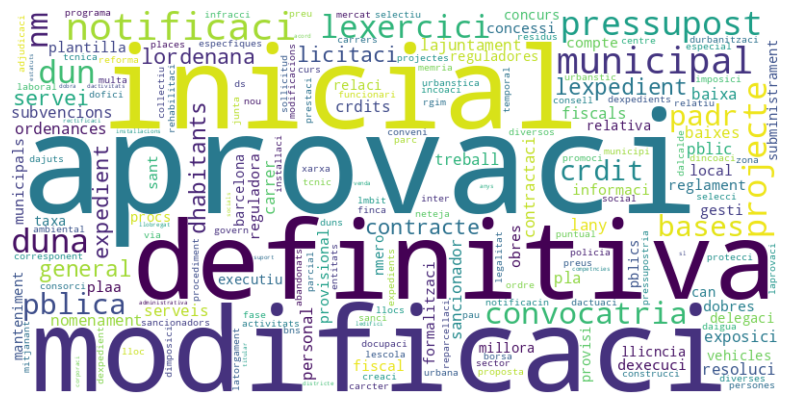

In [15]:
tdm = TermDocMatrix(preprocessed_texts)
word_cloud = CreateWordCloud(tdm, save_file=False)

## Convert texts to TF-IDF vectors

In [12]:
vectorizer = TfidfVectorizer(max_features=1000)

### How many unique words are in texts?

In [13]:
test_vectorizer = TfidfVectorizer()
test_vectorizer.fit(preprocessed_texts)
print(f"Total unique words in corpus: {len(test_vectorizer.vocabulary_)}")

Total unique words in corpus: 26735


In [14]:
X = vectorizer.fit_transform(preprocessed_texts).toarray()
y = np.array(labels)

## Create a PyTorch dataset

In [15]:
class TextDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [16]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train_dataset = DataLoader(TextDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dataset = DataLoader(TextDataset(X_test, y_test), batch_size=32)

# Basic NN

## Model Class

In [21]:
# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Initialize Model, Loss and Optimizer

In [24]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)
summary(fcnn)

Layer (type:depth-idx)                   Param #
FCNN                                     --
├─Linear: 1-1                            256,256
├─ReLU: 1-2                              --
├─Linear: 1-3                            5,397
Total params: 261,653
Trainable params: 261,653
Non-trainable params: 0

## Training and Testing

In [19]:
def train(model, train_loader, optimizer, history):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * target.size(0)
        running_correct += output.argmax(1).eq(target).sum().item()
        running_total  += target.size(0)

    history["train_loss"].append(running_loss / running_total)
    history["train_accuracy"].append(100.0 * running_correct / running_total)


def test(model, test_loader, history):
    model.eval()
    running_loss, running_correct, running_total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            running_loss   += loss_function(output, target).item() * target.size(0)
            running_correct += output.argmax(1).eq(target).sum().item()
            running_total  += target.size(0)

    history["val_loss"].append(running_loss / running_total)
    history["val_accuracy"].append(100.0 * running_correct / running_total)

## History plot

In [8]:
def plot_history(n_epochs, history):
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle("Training Loss and Accuracy")

    # Accuracy plot
    ax1.plot(np.arange(n_epochs), history["train_accuracy"], label="train")
    ax1.plot(np.arange(n_epochs), history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend(loc="lower right")

    # Loss plot
    ax2.plot(np.arange(n_epochs), history["train_loss"],     label="train")
    ax2.plot(np.arange(n_epochs), history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")

    plt.show()

## Fitting function

In [9]:
def fit(model, train_loader, test_loader, optimizer, epochs):
    history = {k: [] for k in ["train_loss", "train_accuracy", "val_loss", "val_accuracy"]}

    for epoch in range(epochs):
        train(model, train_loader, optimizer, history)
        test(model,  test_loader,  history)

        print(f"Epoch {epoch+1:02d}/{epochs} │ "
              f"loss={history['train_loss'][-1]:.4f}  "
              f"val_loss={history['val_loss'][-1]:.4f}  "
              f"acc={history['train_accuracy'][-1]:.2f}%  "
              f"val_acc={history['val_accuracy'][-1]:.2f}%")

    plot_history(epochs, history)
    return history

## Run model

Epoch 01/20 │ loss=0.2980  val_loss=0.1846  acc=91.75%  val_acc=94.45%
Epoch 02/20 │ loss=0.1660  val_loss=0.1743  acc=94.84%  val_acc=94.80%
Epoch 03/20 │ loss=0.1463  val_loss=0.1720  acc=95.33%  val_acc=94.72%
Epoch 04/20 │ loss=0.1309  val_loss=0.1675  acc=95.82%  val_acc=95.02%
Epoch 05/20 │ loss=0.1169  val_loss=0.1693  acc=96.21%  val_acc=95.02%
Epoch 06/20 │ loss=0.1045  val_loss=0.1684  acc=96.61%  val_acc=95.10%
Epoch 07/20 │ loss=0.0927  val_loss=0.1739  acc=96.98%  val_acc=95.02%
Epoch 08/20 │ loss=0.0827  val_loss=0.1746  acc=97.30%  val_acc=95.17%
Epoch 09/20 │ loss=0.0737  val_loss=0.1823  acc=97.59%  val_acc=95.15%
Epoch 10/20 │ loss=0.0652  val_loss=0.1879  acc=97.88%  val_acc=95.01%
Epoch 11/20 │ loss=0.0587  val_loss=0.1944  acc=98.05%  val_acc=95.09%
Epoch 12/20 │ loss=0.0530  val_loss=0.1991  acc=98.20%  val_acc=95.09%
Epoch 13/20 │ loss=0.0485  val_loss=0.2059  acc=98.38%  val_acc=95.15%
Epoch 14/20 │ loss=0.0444  val_loss=0.2138  acc=98.50%  val_acc=95.06%
Epoch 

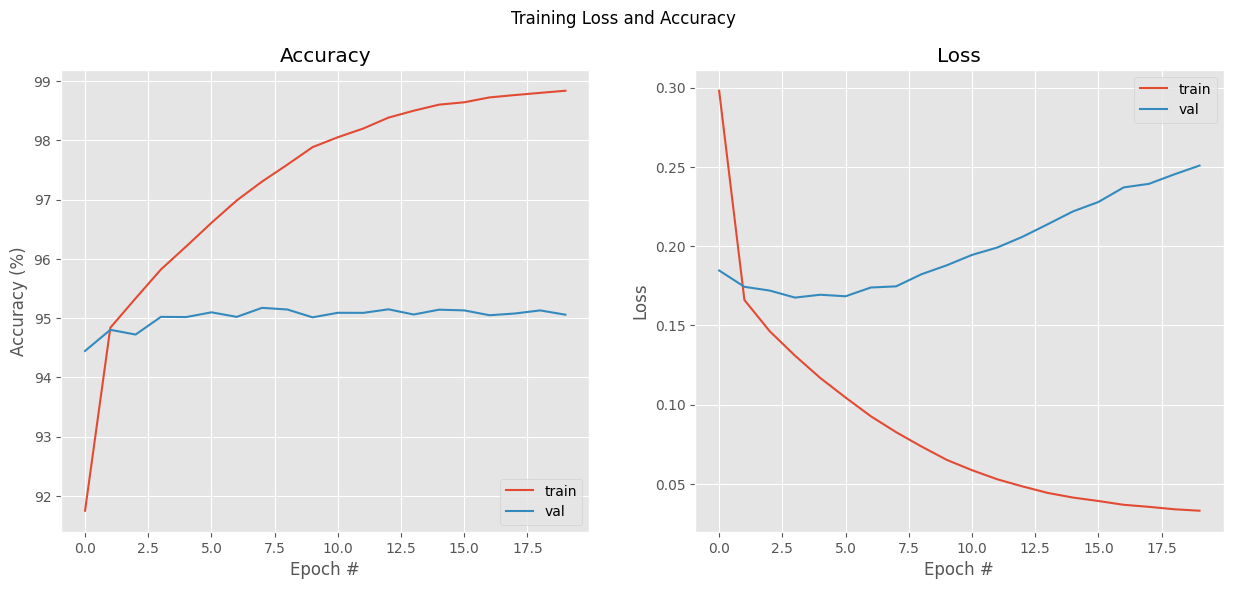

In [19]:
history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
)

There are clear overfitting issues with this model.

# Transformer model

In [20]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import evaluate
import accelerate

/mnt/d/MEGA/MÀSTER MODELLING/2 - Mathematics for Big Data/3. DeepLearning/MBD_NN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-10 21:55:12.888285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749585312.951648   18746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749585312.969007   18746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749585313.108672   18746 computation_placer.cc:177] computation placer already registered. Please check

Hugging face BERT-like models expects tokenized inputs (This is done by lazy-tokenization):

In [34]:
df = pd.DataFrame({
    "text": preprocessed_texts,
    "label": labels
})

train_tok, test_tok = train_test_split(df, test_size=0.25,
                                       stratify=labels, random_state=0)

train_tok = Dataset.from_pandas(train_tok)
test_tok   = Dataset.from_pandas(test_tok)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True
                     )

# Convert to HuggingFace Dataset object to be able to use .map()
# train_dataset = Dataset.from_dict({"text": X_train_tok, "label": y_train_tok})
# test_dataset  = Dataset.from_dict({"text": X_test_tok,  "label": y_test_tok})
train_tok = train_tok.map(tokenize)
test_tok  = test_tok.map(tokenize)

train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 54244/54244 [00:10<00:00, 5329.54 examples/s]


In [35]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=21,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer wrapping (so it can be used as a sklearn-like model).

In [38]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

args = TrainingArguments(
    output_dir=".outputs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    num_train_epochs=2,           # 2-3 epochs usually fine when fine-tuning
    fp16=True,
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Run the model.

In [39]:
trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.211900,0.201387,0.954742
2,0.147700,0.162076,0.963093


{'eval_loss': 0.16207608580589294,
 'eval_accuracy': 0.9630926922793305,
 'eval_runtime': 136.7285,
 'eval_samples_per_second': 396.728,
 'eval_steps_per_second': 49.595,
 'epoch': 2.0}

FINAL NOTES: since the transformer model DOES NOT perform better than the FCNN, we will modify the FCNN in order to reduce the overfitting issue. We will also try training using per-year data and see its performance when predicting over the following year's data.

# FCNN: Dealing with overfitting

## Adding Dropout layer and Batch Normalization

`Dropout` randomly disables some neurons during training, forcing the model to generalize better whereas `Batch Normalization` helps in stabilizing and regularizing the training, especially in deeper networks.

In [17]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)

        return out

Epoch 01/20 │ loss=0.3564  val_loss=0.1965  acc=90.32%  val_acc=94.18%
Epoch 02/20 │ loss=0.2440  val_loss=0.1798  acc=93.02%  val_acc=94.64%
Epoch 03/20 │ loss=0.2217  val_loss=0.1729  acc=93.61%  val_acc=94.78%
Epoch 04/20 │ loss=0.2071  val_loss=0.1700  acc=93.93%  val_acc=94.90%
Epoch 05/20 │ loss=0.1957  val_loss=0.1699  acc=94.19%  val_acc=95.06%
Epoch 06/20 │ loss=0.1863  val_loss=0.1693  acc=94.47%  val_acc=94.91%
Epoch 07/20 │ loss=0.1786  val_loss=0.1638  acc=94.65%  val_acc=95.09%
Epoch 08/20 │ loss=0.1719  val_loss=0.1641  acc=94.80%  val_acc=95.14%
Epoch 09/20 │ loss=0.1683  val_loss=0.1650  acc=94.93%  val_acc=95.20%
Epoch 10/20 │ loss=0.1627  val_loss=0.1652  acc=95.05%  val_acc=95.23%
Epoch 11/20 │ loss=0.1598  val_loss=0.1662  acc=95.14%  val_acc=95.19%
Epoch 12/20 │ loss=0.1559  val_loss=0.1633  acc=95.25%  val_acc=95.24%
Epoch 13/20 │ loss=0.1526  val_loss=0.1643  acc=95.34%  val_acc=95.29%
Epoch 14/20 │ loss=0.1474  val_loss=0.1666  acc=95.46%  val_acc=95.25%
Epoch 

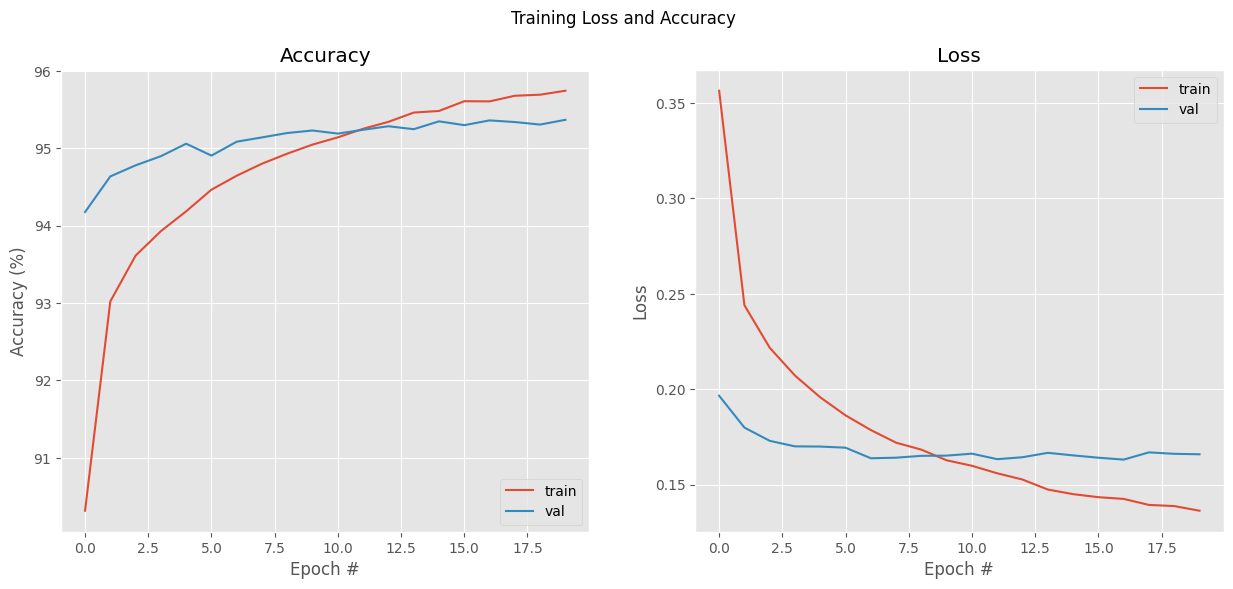

In [20]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
)

We can see the overfitting has improved at the cost of reducing slightly the training accuracy of the model.

## Yearly data distribution for train and testing

Now we will use data from a specific year as the validation set, and data from the previous year as the training set. This approach helps estimate the model’s predictive power on future (unseen) data, simulating how it might perform on the final test set.

Notice we define the vectorizer and the fcnn outside the loop: 
1. We are fiting the vectorizer with the entire preprocess data. 
2. The fcnn has its weights improved in each year.

`train` and `test` functions are modified here so they can be run on GPU.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, history):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for data, target in train_loader:

        # Modifications to send data to GPU
        data = data.to(device).float()
        target = target.to(device).long()
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * target.size(0)
        running_correct += output.argmax(1).eq(target).sum().item()
        running_total  += target.size(0)

    history["train_loss"].append(running_loss / running_total)
    history["train_accuracy"].append(100.0 * running_correct / running_total)


def test(model, test_loader, history):
    model.eval()
    running_loss, running_correct, running_total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:

            # Modifications to send data to GPU
            data = data.to(device).float()
            target = target.to(device).long()
            
            output = model(data)
            running_loss   += loss_function(output, target).item() * target.size(0)
            running_correct += output.argmax(1).eq(target).sum().item()
            running_total  += target.size(0)

    history["val_loss"].append(running_loss / running_total)
    history["val_accuracy"].append(100.0 * running_correct / running_total)

Length Traing data: 33770
Length Test data: 36589
Epoch 01/20 │ loss=0.5158  val_loss=0.2781  acc=86.39%  val_acc=92.05%
Epoch 02/20 │ loss=0.2451  val_loss=0.2665  acc=92.95%  val_acc=92.61%
Epoch 03/20 │ loss=0.2070  val_loss=0.2598  acc=93.91%  val_acc=92.63%
Epoch 04/20 │ loss=0.1801  val_loss=0.2698  acc=94.75%  val_acc=92.65%
Epoch 05/20 │ loss=0.1650  val_loss=0.2689  acc=94.98%  val_acc=92.64%
Epoch 06/20 │ loss=0.1510  val_loss=0.2773  acc=95.40%  val_acc=93.00%
Epoch 07/20 │ loss=0.1411  val_loss=0.2808  acc=95.74%  val_acc=92.95%
Epoch 08/20 │ loss=0.1313  val_loss=0.2844  acc=95.85%  val_acc=92.98%
Epoch 09/20 │ loss=0.1223  val_loss=0.3064  acc=96.23%  val_acc=92.78%
Epoch 10/20 │ loss=0.1160  val_loss=0.3054  acc=96.35%  val_acc=92.98%
Epoch 11/20 │ loss=0.1130  val_loss=0.3051  acc=96.44%  val_acc=93.02%
Epoch 12/20 │ loss=0.1037  val_loss=0.3245  acc=96.84%  val_acc=92.79%
Epoch 13/20 │ loss=0.0974  val_loss=0.3226  acc=96.88%  val_acc=92.93%
Epoch 14/20 │ loss=0.1028  

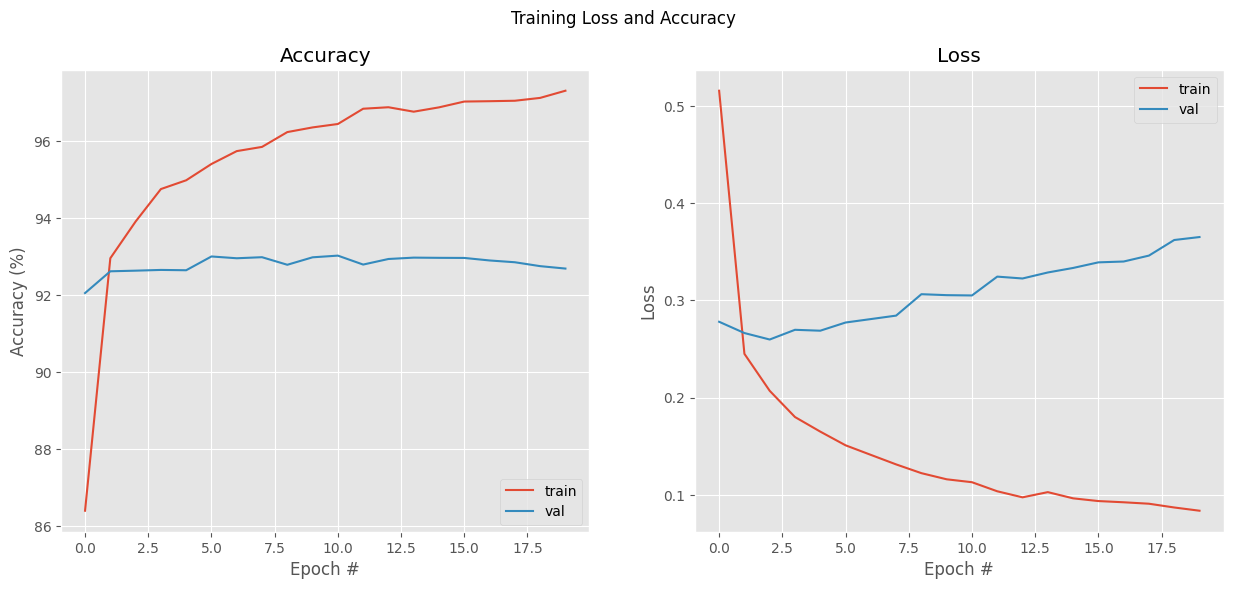

Length Traing data: 70359
Length Test data: 29412
Epoch 01/20 │ loss=0.2171  val_loss=0.2855  acc=94.26%  val_acc=92.17%
Epoch 02/20 │ loss=0.1711  val_loss=0.2551  acc=94.89%  val_acc=92.99%
Epoch 03/20 │ loss=0.1535  val_loss=0.2673  acc=95.29%  val_acc=92.64%
Epoch 04/20 │ loss=0.1471  val_loss=0.2747  acc=95.45%  val_acc=92.58%
Epoch 05/20 │ loss=0.1404  val_loss=0.2589  acc=95.52%  val_acc=93.18%
Epoch 06/20 │ loss=0.1317  val_loss=0.2553  acc=95.80%  val_acc=93.39%
Epoch 07/20 │ loss=0.1279  val_loss=0.2580  acc=95.93%  val_acc=93.32%
Epoch 08/20 │ loss=0.1264  val_loss=0.2574  acc=95.98%  val_acc=93.44%
Epoch 09/20 │ loss=0.1196  val_loss=0.2701  acc=96.17%  val_acc=93.27%
Epoch 10/20 │ loss=0.1194  val_loss=0.2709  acc=96.12%  val_acc=93.30%
Epoch 11/20 │ loss=0.1156  val_loss=0.2660  acc=96.25%  val_acc=93.52%
Epoch 12/20 │ loss=0.1138  val_loss=0.2727  acc=96.37%  val_acc=93.39%
Epoch 13/20 │ loss=0.1106  val_loss=0.2781  acc=96.39%  val_acc=93.39%
Epoch 14/20 │ loss=0.1108  

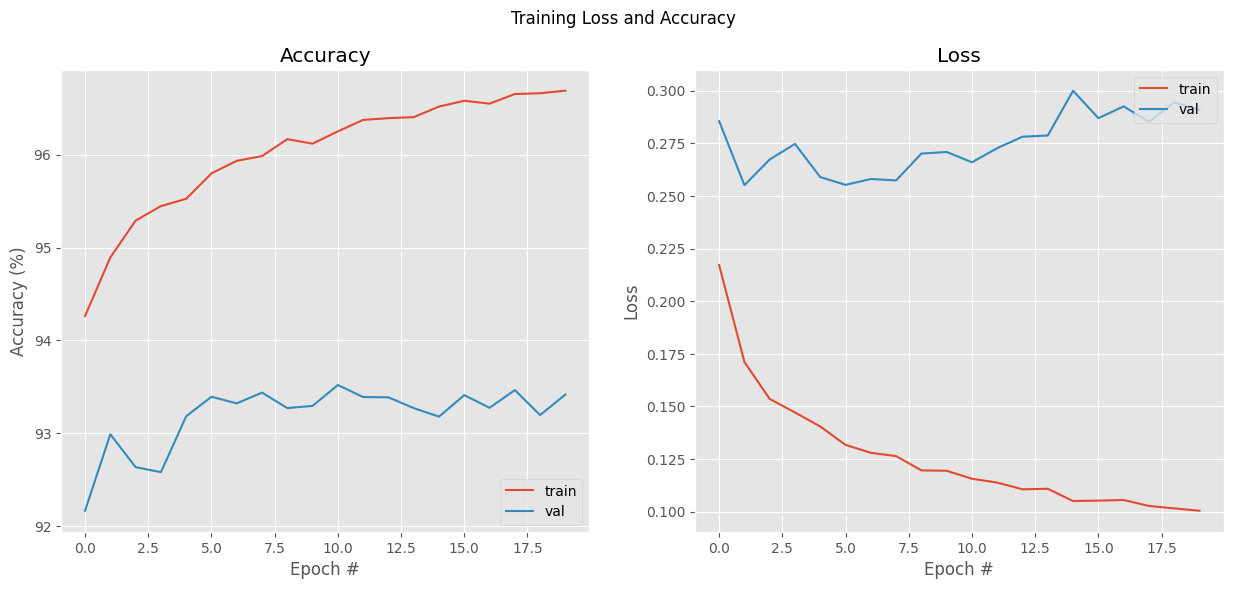

Length Traing data: 99771
Length Test data: 23589
Epoch 01/20 │ loss=0.1639  val_loss=0.2460  acc=95.44%  val_acc=93.49%
Epoch 02/20 │ loss=0.1434  val_loss=0.2488  acc=95.66%  val_acc=93.65%
Epoch 03/20 │ loss=0.1334  val_loss=0.2490  acc=95.88%  val_acc=93.76%
Epoch 04/20 │ loss=0.1293  val_loss=0.2479  acc=95.95%  val_acc=93.62%
Epoch 05/20 │ loss=0.1256  val_loss=0.2527  acc=96.09%  val_acc=93.73%
Epoch 06/20 │ loss=0.1224  val_loss=0.2589  acc=96.11%  val_acc=93.71%
Epoch 07/20 │ loss=0.1200  val_loss=0.2650  acc=96.23%  val_acc=93.79%
Epoch 08/20 │ loss=0.1197  val_loss=0.2595  acc=96.19%  val_acc=93.81%
Epoch 09/20 │ loss=0.1138  val_loss=0.2672  acc=96.28%  val_acc=93.70%
Epoch 10/20 │ loss=0.1149  val_loss=0.2671  acc=96.36%  val_acc=93.77%
Epoch 11/20 │ loss=0.1098  val_loss=0.2740  acc=96.49%  val_acc=93.67%
Epoch 12/20 │ loss=0.1105  val_loss=0.2774  acc=96.44%  val_acc=93.73%
Epoch 13/20 │ loss=0.1080  val_loss=0.2811  acc=96.57%  val_acc=93.81%
Epoch 14/20 │ loss=0.1086  

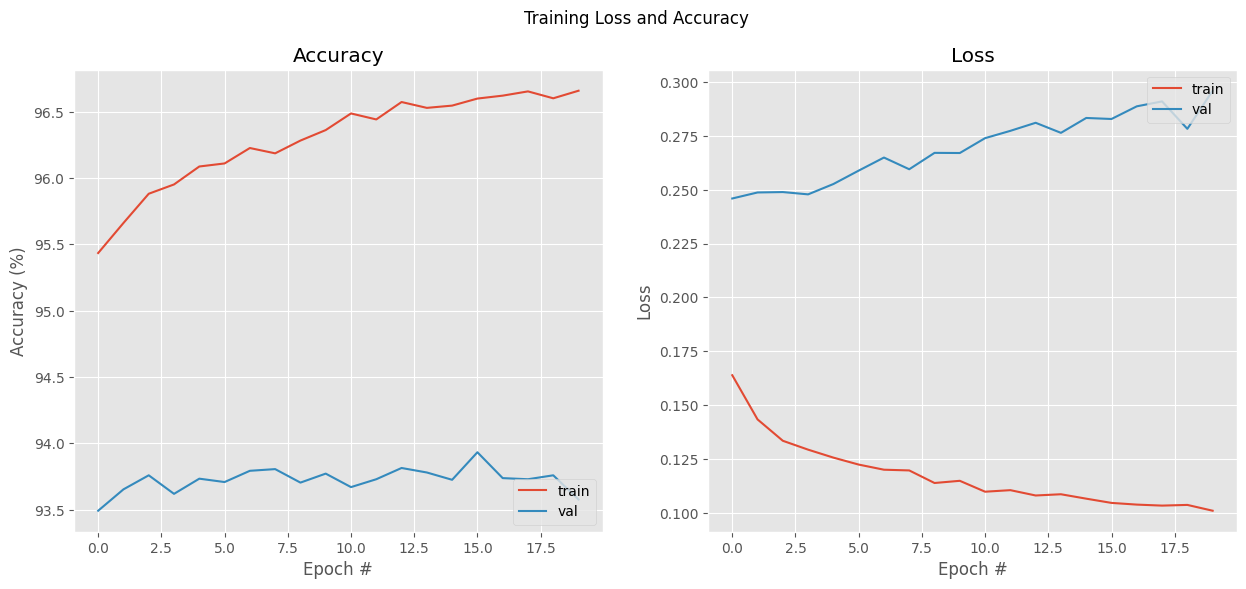

Length Traing data: 123360
Length Test data: 25813
Epoch 01/20 │ loss=0.1453  val_loss=0.2192  acc=95.87%  val_acc=94.48%
Epoch 02/20 │ loss=0.1333  val_loss=0.2095  acc=96.03%  val_acc=94.58%
Epoch 03/20 │ loss=0.1266  val_loss=0.2096  acc=96.14%  val_acc=94.77%
Epoch 04/20 │ loss=0.1240  val_loss=0.2093  acc=96.18%  val_acc=94.73%
Epoch 05/20 │ loss=0.1215  val_loss=0.2112  acc=96.24%  val_acc=94.70%
Epoch 06/20 │ loss=0.1192  val_loss=0.2136  acc=96.24%  val_acc=94.75%
Epoch 07/20 │ loss=0.1156  val_loss=0.2185  acc=96.43%  val_acc=94.69%
Epoch 08/20 │ loss=0.1150  val_loss=0.2134  acc=96.32%  val_acc=94.75%
Epoch 09/20 │ loss=0.1146  val_loss=0.2124  acc=96.40%  val_acc=94.80%
Epoch 10/20 │ loss=0.1113  val_loss=0.2193  acc=96.50%  val_acc=94.85%
Epoch 11/20 │ loss=0.1105  val_loss=0.2221  acc=96.48%  val_acc=94.86%
Epoch 12/20 │ loss=0.1116  val_loss=0.2237  acc=96.39%  val_acc=94.79%
Epoch 13/20 │ loss=0.1075  val_loss=0.2285  acc=96.55%  val_acc=94.79%
Epoch 14/20 │ loss=0.1073 

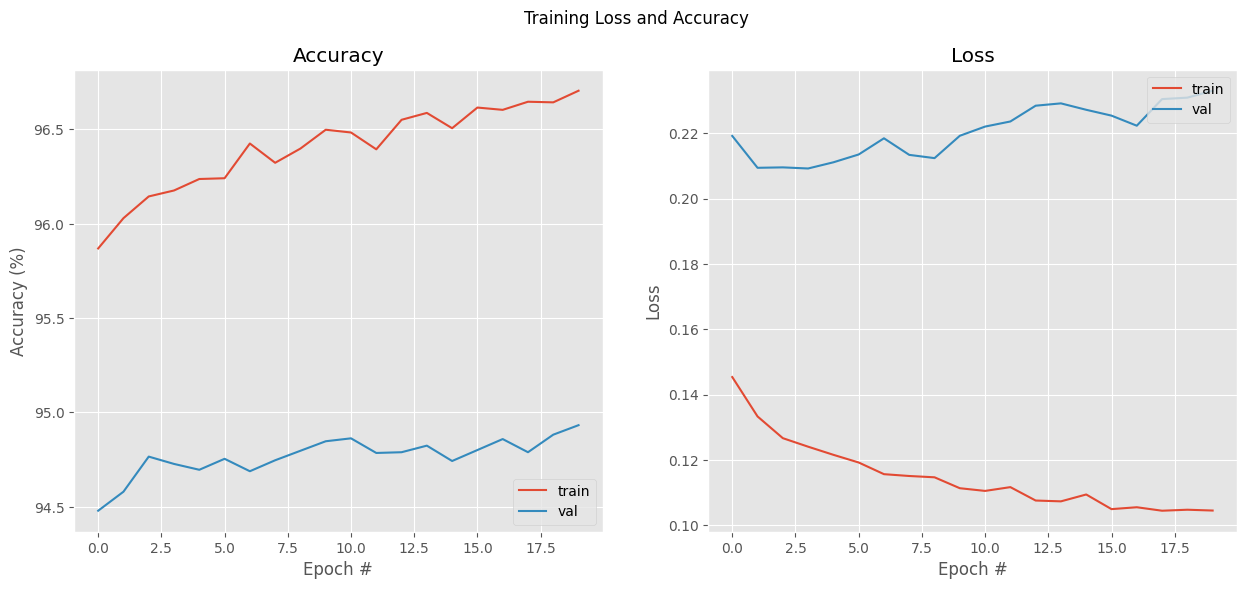

Length Traing data: 149173
Length Test data: 24734
Epoch 01/20 │ loss=0.1386  val_loss=0.2257  acc=96.05%  val_acc=94.38%
Epoch 02/20 │ loss=0.1284  val_loss=0.2192  acc=96.19%  val_acc=94.46%
Epoch 03/20 │ loss=0.1247  val_loss=0.2151  acc=96.20%  val_acc=94.44%
Epoch 04/20 │ loss=0.1234  val_loss=0.2198  acc=96.24%  val_acc=94.57%
Epoch 05/20 │ loss=0.1211  val_loss=0.2157  acc=96.27%  val_acc=94.67%
Epoch 06/20 │ loss=0.1190  val_loss=0.2178  acc=96.34%  val_acc=94.53%
Epoch 07/20 │ loss=0.1158  val_loss=0.2196  acc=96.35%  val_acc=94.61%
Epoch 08/20 │ loss=0.1170  val_loss=0.2169  acc=96.35%  val_acc=94.71%
Epoch 09/20 │ loss=0.1164  val_loss=0.2187  acc=96.43%  val_acc=94.64%
Epoch 10/20 │ loss=0.1137  val_loss=0.2193  acc=96.42%  val_acc=94.75%
Epoch 11/20 │ loss=0.1127  val_loss=0.2220  acc=96.49%  val_acc=94.70%
Epoch 12/20 │ loss=0.1123  val_loss=0.2215  acc=96.50%  val_acc=94.70%
Epoch 13/20 │ loss=0.1116  val_loss=0.2200  acc=96.49%  val_acc=94.56%
Epoch 14/20 │ loss=0.1095 

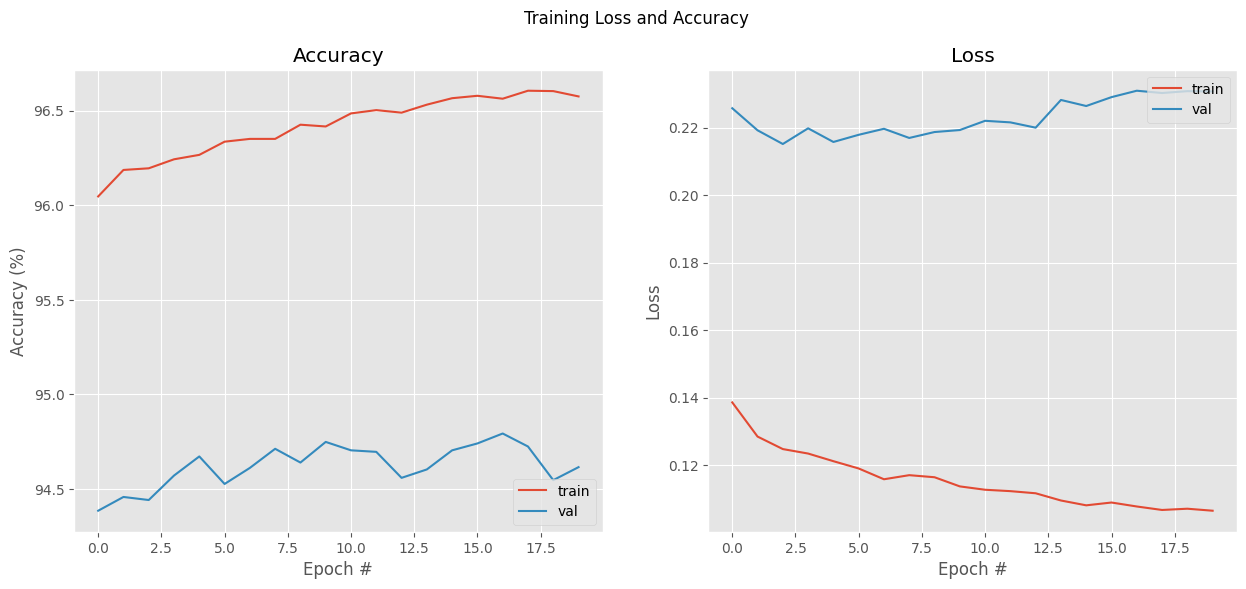

Length Traing data: 173907
Length Test data: 22365
Epoch 01/20 │ loss=0.1340  val_loss=0.1900  acc=96.13%  val_acc=94.97%
Epoch 02/20 │ loss=0.1278  val_loss=0.1944  acc=96.19%  val_acc=94.94%
Epoch 03/20 │ loss=0.1246  val_loss=0.1970  acc=96.26%  val_acc=94.99%
Epoch 04/20 │ loss=0.1236  val_loss=0.1928  acc=96.25%  val_acc=94.95%
Epoch 05/20 │ loss=0.1207  val_loss=0.1922  acc=96.30%  val_acc=95.03%
Epoch 06/20 │ loss=0.1200  val_loss=0.1933  acc=96.30%  val_acc=95.08%
Epoch 07/20 │ loss=0.1174  val_loss=0.1886  acc=96.34%  val_acc=95.11%
Epoch 08/20 │ loss=0.1165  val_loss=0.1866  acc=96.35%  val_acc=95.15%
Epoch 09/20 │ loss=0.1150  val_loss=0.1962  acc=96.40%  val_acc=95.14%
Epoch 10/20 │ loss=0.1164  val_loss=0.1888  acc=96.39%  val_acc=95.14%
Epoch 11/20 │ loss=0.1165  val_loss=0.1890  acc=96.35%  val_acc=95.15%
Epoch 12/20 │ loss=0.1143  val_loss=0.1873  acc=96.43%  val_acc=95.31%
Epoch 13/20 │ loss=0.1132  val_loss=0.1895  acc=96.48%  val_acc=95.34%
Epoch 14/20 │ loss=0.1124 

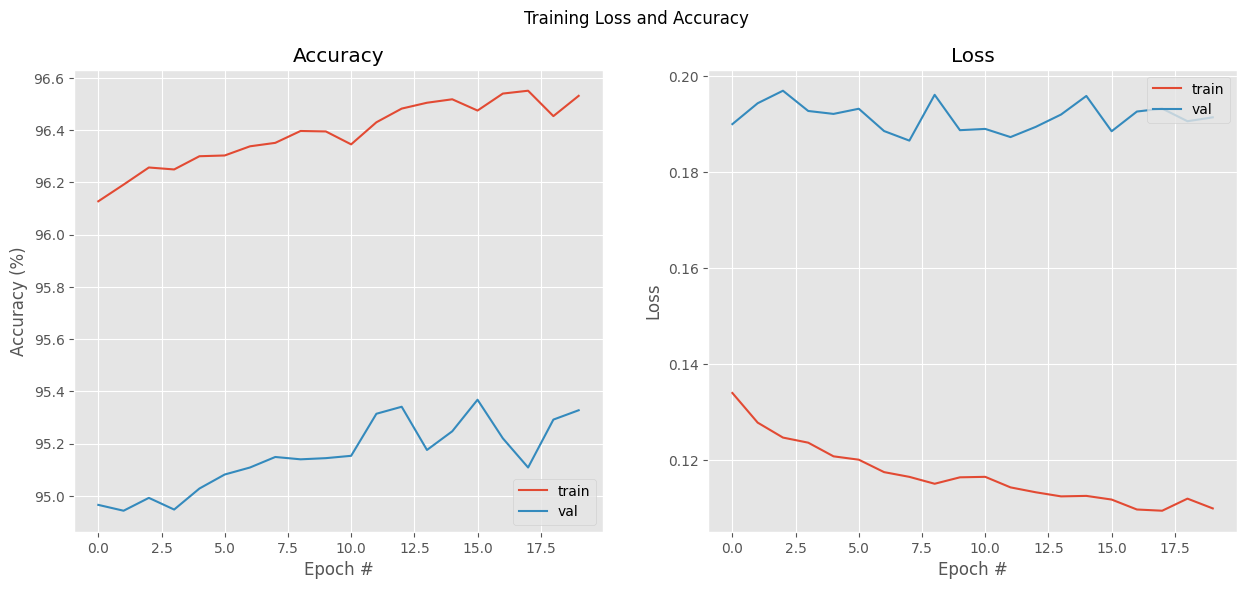

Length Traing data: 196272
Length Test data: 20702
Epoch 01/20 │ loss=0.1277  val_loss=0.2877  acc=96.24%  val_acc=93.89%
Epoch 02/20 │ loss=0.1234  val_loss=0.2923  acc=96.27%  val_acc=93.95%
Epoch 03/20 │ loss=0.1217  val_loss=0.2880  acc=96.32%  val_acc=93.96%
Epoch 04/20 │ loss=0.1207  val_loss=0.2921  acc=96.32%  val_acc=93.99%
Epoch 05/20 │ loss=0.1179  val_loss=0.2833  acc=96.40%  val_acc=94.04%
Epoch 06/20 │ loss=0.1172  val_loss=0.2882  acc=96.41%  val_acc=93.95%
Epoch 07/20 │ loss=0.1172  val_loss=0.2943  acc=96.39%  val_acc=94.01%
Epoch 08/20 │ loss=0.1176  val_loss=0.2873  acc=96.37%  val_acc=94.06%
Epoch 09/20 │ loss=0.1177  val_loss=0.3060  acc=96.30%  val_acc=94.02%
Epoch 10/20 │ loss=0.1152  val_loss=0.2898  acc=96.45%  val_acc=93.93%
Epoch 11/20 │ loss=0.1146  val_loss=0.2950  acc=96.43%  val_acc=94.02%
Epoch 12/20 │ loss=0.1142  val_loss=0.2973  acc=96.44%  val_acc=94.02%
Epoch 13/20 │ loss=0.1143  val_loss=0.2942  acc=96.43%  val_acc=94.02%
Epoch 14/20 │ loss=0.1135 

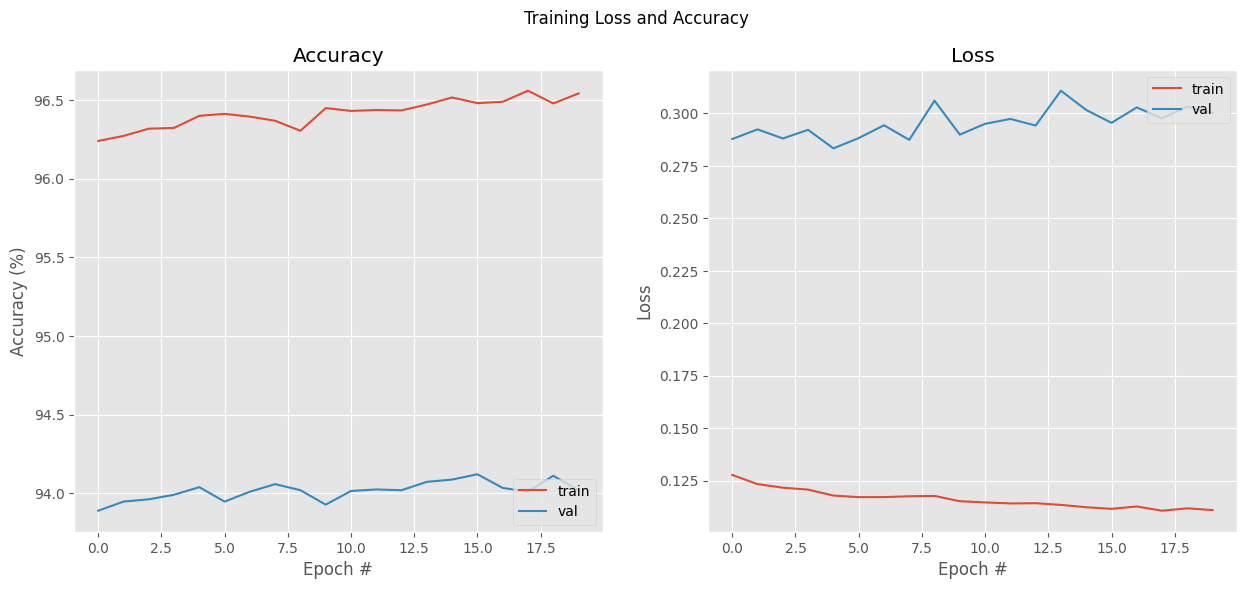

In [22]:
year_num = 2014
val_acc_history = {}

vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(preprocessed_texts)

fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

while year_num <= 2020:

    X = vectorizer.transform([text for text, y in zip(preprocessed_texts, year) if y < year_num]).toarray()
    y = np.array([text for text, y_ in zip(labels, year) if y_ < year_num])
    print(f'Length Traing data: {len(y)}')
    train_dataset = DataLoader(TextDataset(X, y), batch_size=32, shuffle=True)

    X = vectorizer.transform([text for text, y in zip(preprocessed_texts, year) if y == year_num]).toarray()
    y = np.array([text for text, y_ in zip(labels, year) if y_ == year_num])
    print(f'Length Test data: {len(y)}')    
    test_dataset = DataLoader(TextDataset(X, y), batch_size=32)

    history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
    )

    val_acc_history[year_num] = history['val_accuracy'][-1]

    year_num += 1

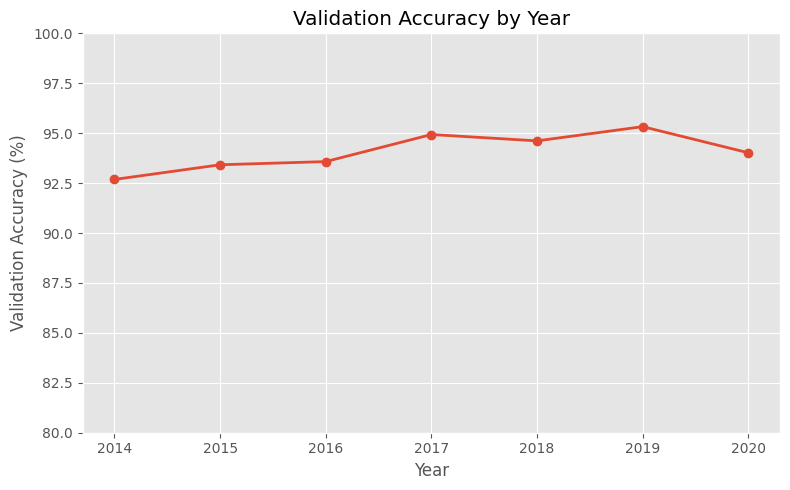

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(list(val_acc_history.keys()),
         list(val_acc_history.values()),
         marker='o',linestyle='-', linewidth=2)
plt.title('Validation Accuracy by Year')
plt.xlabel('Year')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True)
plt.ylim(80, 100)
plt.xticks(list(val_acc_history.keys()))
plt.tight_layout()
plt.show()

In [23]:
from scipy import stats

values = np.array(list(val_acc_history.values()))
n = len(values)
mean = np.mean(values)
std_dev = np.std(values, ddof=1)

t_critical = stats.t.ppf(1 - 0.025, df=n-1)
margin_of_error = t_critical * (std_dev / np.sqrt(n))
ci_lower = mean - margin_of_error
ci_upper = mean + margin_of_error

print(f"Mean: {mean:.2f}")
print(f"95% Confidence Interval: [{ci_lower:.2f}-{ci_upper:.2f}]")

Mean: 94.08
95% Confidence Interval: [93.22-94.94]
